iv. Can one use regression to associate CREs with gene expression?

    - a. How much of the variance of gene expression can be explained for each gene with this approach?

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os

DATA_DIR = "data/"
DATA_PROC_DIR = "data-processed/"
ATAC_SEQ_PATH = os.path.join(DATA_DIR, "ImmGenATAC18_AllOCRsInfo.csv")
RNA_SEQ_PATH = os.path.join(DATA_DIR, "mmc2.csv")
#REFFLAT_PATH = os.path.join(DATA_DIR, "refFlat.txt.gz")
PROC_PEAKS_PATH = os.path.join(DATA_PROC_DIR, "peaks_annotated.csv")

# --- 1. Load Data ---
# 1.1 CRE annotations (must include 'peak_id' and 'nearest_gene')
peaks = pd.read_csv(PROC_PEAKS_PATH)
#peaks["peak_id"] = peaks.index  # ensure a unique integer ID

# 1.2 ATAC accessibility (peaks × cellTypes)
atac = pd.read_csv(ATAC_SEQ_PATH, index_col=[0,1,2])#.drop(["mm10.60way.phastCons_scores", "_-log10_bestPvalue", "Included.in.systematic.analysis"])
atac = atac.select_dtypes(include=[np.number])
#atac = atac.mean(axis=1, numeric_only=True)
#atac.index.names = ["chrom","start","end"]

# 1.3 RNA expression (genes × cellTypes)
rna = pd.read_csv(RNA_SEQ_PATH, index_col=0)
#rna = rna.mean(axis=1, numeric_only=True)

# **Align** to only the intersection of cell types
common_cells = atac.columns.intersection(rna.columns)
if len(common_cells) < len(atac.columns) or len(common_cells) < len(rna.columns):
    print(f"Aligning to {len(common_cells)} common cell types "
          f"(was {len(atac.columns)} ATAC, {len(rna.columns)} RNA)")
atac = atac[common_cells]
rna  = rna[common_cells]

# --- 2. Build gene → CRE mapping ---
# We'll use the 'TSS_GeneName' field to link peaks to their gene.
#gene_to_peaks = peaks.groupby("TSS_GeneName")["id"].apply(list).to_dict()

# 2.1 Explode the gene lists
peaks["gene_list"] = peaks["genes.within.100Kb"].str.split(",")
peaks_exploded = peaks.explode("gene_list").rename(columns={"gene_list":"gene"})
# Drop any empty gene entries
peaks_exploded = peaks_exploded[peaks_exploded["gene"].notna() & (peaks_exploded["gene"]!="")]

# 2.2 Group to get mapping: gene → list of peak_ids
gene_to_peaks = peaks_exploded.groupby("gene")["id"].apply(list).to_dict()




Aligning to 85 common cell types (was 93 ATAC, 86 RNA)


In [ ]:

# --- 3. Fit regression per gene ---
results = []
model = LinearRegression()

for gene, peak_ids in gene_to_peaks.items():
    # skip if gene not in RNA or too few CREs
    if gene not in rna.index or len(peak_ids) < 2:
        continue

    # Build X: shape (n_cellTypes, n_peaks)

    sub = atac.loc[peak_ids]  # DataFrame: rows=CREs, cols=cell types

    # Option A: DROP any CRE row with NA
    sub_clean = sub.dropna(axis=0, how="any")
    if sub_clean.shape[0] < 2:
        continue

    X = sub_clean.values.T  # transpose → samples × features
    #X = X.reshape(1, -1)


    # Build y: expression vector for this gene across same cellTypes
    y = rna.loc[gene].values
    #y = np.array(rna.loc[gene])
    #y = y.reshape(-1, 1)  # ensure y is a column vector
    #print(X)
    #print("y:")
    #print(y)

    # Fit and record R^2
    try:
        model.fit(X, y)
        r2 = model.score(X, y)
    except Exception as e:
        logging.warning(f"Regression failed for {gene}: {e}")
        continue

    results.append({"gene": gene, "R2": r2, "n_CRes": len(peak_ids)})

# --- 4. Summarize results ---
r2_df = pd.DataFrame(results).sort_values("R2", ascending=False)
r2_df.to_csv("data-processed/gene_variance_explained.csv", index=False)

print(f"Computed R² for {len(r2_df)} genes.")
r2_df

Computed R² for 17469 genes.


,gene,R2,n_CRes
17464,Zyx,1.000000,105
0,0610005C13Rik,1.000000,96
17455,Zswim8,1.000000,100
17453,Zswim6,1.000000,108
3,0610009L18Rik,1.000000,89
...,...,...,...
12816,Rhox5,0.002482,2
1049,Adam34,0.002237,3
6667,Gm5797,0.001803,5
7007,Grm3,0.000940,2


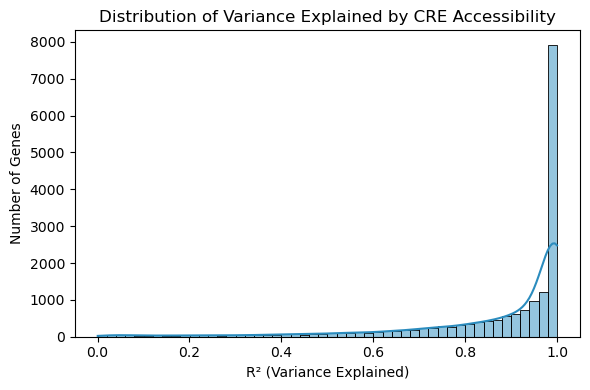

count    17469.000000
mean         0.873958
std          0.198776
min          0.000491
25%          0.830172
50%          0.967230
75%          1.000000
max          1.000000


In [18]:

# --- 5. Plot distribution of R² ---
#sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.histplot(r2_df["R2"], bins=50, kde=True, color="#2b8cbe")
plt.xlabel("R² (Variance Explained)")
plt.ylabel("Number of Genes")
plt.title("Distribution of Variance Explained by CRE Accessibility")
plt.tight_layout()
#plt.savefig("reports/R2_distribution.png", dpi=300)
plt.show()

# Optional: print summary statistics
print(r2_df["R2"].describe().to_string())